In [12]:
import numpy as np
import pandas as pd
from scipy.integrate import solve_ivp
import math
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline 
import plotly.graph_objects as go
import plotly.io as pio

In [13]:
# The SEIR ODEs used by solve_ivp
def seir_ode(times, init, args):
    
    '''
    SEIR ODEs
    '''

    exposed_rate, recovery_rate, unreported, infectivity, infectivity_reduction, contacts, contact_reduction, population = args
    susceptible, exposed, infected_u, infected_r, recovered1, recovered2 = np.split(init, [3, 6, 9, 12, 15])
    transmission_rate = ((contacts * contact_reduction * infectivity).T / population).T

    dS_out = ( ((transmission_rate*susceptible).T).dot( (1-infectivity_reduction[0]) * infected_u + (1-infectivity_reduction[1]) * infected_r) )
    dE_out = exposed * 1/exposed_rate
    dI_u_out = infected_u * 1/recovery_rate
    dI_r_out = infected_r * 1/recovery_rate
    dR1_out = recovered1 * 1/recovery_rate

    dS = -dS_out
    dE = dS_out - dE_out
    dI_u = (dE_out * unreported) - dI_u_out
    dI_r = (dE_out * ([1 - value for value in unreported])) - dI_r_out
    dR1 = (dI_u_out + dI_r_out) - dR1_out
    dR2 = dR1_out

    return np.concatenate((dS, dE, dI_u, dI_r, dR1, dR2))

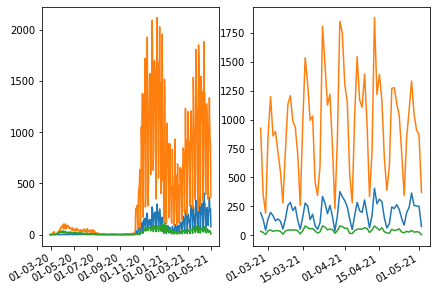

In [14]:
data = pd.read_csv("../dataset/antal_fall_Stockholm_v15.csv", encoding = "latin1")
data = data.set_index("Statistikdatum")

data.index = pd.to_datetime(data.index)

data_values = (data.Infected019 + data.Infected2069 + data.Infected70).values

spring = data[data.period == 'spring']
autumn = data[data.period == 'autumn']

fig, ax = plt.subplots(1,2)
fig.autofmt_xdate()
fig.tight_layout()

ax[0].plot(data[["Infected019", "Infected2069", "Infected70"]])
ax[1].plot(data[["Infected019", "Infected2069", "Infected70"]][365:])


xfmt = mdates.DateFormatter('%d-%m-%y')
ax[0].xaxis.set_major_formatter(xfmt)
ax[1].xaxis.set_major_formatter(xfmt)


In [15]:
population = np.array([566_994.0, 1528112.0, 279444.0]) # (0-19, 20-69, 70+)

susceptible = np.array([566_994.0, 1528112.0 - 1, 279444.0])
exposed = np.array([0.0, 0.0, 0.0])
infected_r = np.array([0.0, 0.0, 0.0]) # reported
infected_u = np.array([0.0, 1.0, 0.0]) # reported
recovered1 = np.array([0.0, 0.0, 0.0]) # PCR-positive
recovered2 = np.array([0.0, 0.0, 0.0]) # PCR-negative

contacts = np.array([7.452397574, 4.718777779, 0.290063626, 1.764106486, 8.544229624, 0.624169322, 0.443861795, 2.55482785, 1.69]).reshape(3, 3)

#variables after fitting
infectivity019_p1 = 23.53349159354256/100.0
infectivity2069_p1 = 15.661790850166916/100.0
infectivity70_p1 = 25.98042750357819/100.0

infectivity019_p2 = 44.62199710193084/100.0
infectivity2069_p2 = 4.1112260686976825/100.0
infectivity70_p2 = 5.360966821275955/100.0

unreported_019_p1 = 0.998416430249021
unreported_2069_p1 = 0.986717837070985
unreported_70_p1 = 0.8639400113485507

unreported_0_19_p2 = 0.5755026399435202
unreported_20_69_p2 = 0.4763668186715981
unreported_70_p2 = 0.01



contact_reduction = np.array([1] * 9).reshape(3,3) # (0-19, 20-69, 70+) x (0-19, 20-69, 70+)


infectivity = np.array([infectivity019_p2, infectivity2069_p2, infectivity70_p2]) # 0-19, 20-69, 70+
unreported = np.array([unreported_0_19_p2, unreported_20_69_p2, unreported_70_p2])

infectivity_reduction = np.array([0.5, 0.0]) # unreported, reported

exposed_rate = 5.1
recovery_rate = 5.0

# Arguments used by seir_ode
args = (exposed_rate, recovery_rate, unreported, infectivity, infectivity_reduction, contacts, contact_reduction, population)

# Initial compartments. solve_ivp requires a 1-d array we therefore have to concatenate the arrays.
init = np.concatenate((susceptible, exposed, infected_u, infected_r, recovered1, recovered2))

# Time steps

#times = np.linspace(0,len(data_values) - 1 , len(data_values))

# Time steps
aut = autumn[:130]
times = np.linspace(0,len(aut) - 1 , len(aut))
# Solve the ODEs
seir_sol = solve_ivp(fun=lambda t, y: seir_ode(t, y, args), t_span=[min(times),max(times)], y0=init, t_eval=times)

In [21]:
susceptible = seir_sol["y"][0][:] + seir_sol["y"][1][:] + seir_sol["y"][2][:]
exposed = seir_sol["y"][3][:] + seir_sol["y"][4][:] + seir_sol["y"][5][:]
infected_u = seir_sol["y"][6][:] + seir_sol["y"][7][:] + seir_sol["y"][8][:]
infected_r = seir_sol["y"][9][:] + seir_sol["y"][10][:] + seir_sol["y"][11][:]
recovered1 = seir_sol["y"][12][:] + seir_sol["y"][13][:] + seir_sol["y"][14][:]
recovered2 = seir_sol["y"][15][:] + seir_sol["y"][16][:] + seir_sol["y"][17][:]

In [22]:
infected019_p2 = seir_sol["y"][3][:] * 1 / exposed_rate * (1-unreported_0_19_p2)
infected2069_p2 = seir_sol["y"][4][:] * 1 / exposed_rate * (1-unreported_20_69_p2)
infected70_p2 = seir_sol["y"][5][:] * 1 / exposed_rate * (1-unreported_70_p2)
incidence_reported = infected70_p2 + infected2069_p2  + infected019_p2

infected019_p2_u = seir_sol["y"][3][:] * 1 / exposed_rate * (unreported_0_19_p2)
infected2069_p2_u = seir_sol["y"][4][:] * 1 / exposed_rate * (unreported_20_69_p2)
infected70_p2_u = seir_sol["y"][5][:] * 1 / exposed_rate * (unreported_70_p2)
incidence_unreported = infected70_p2_u + infected2069_p2_u  + infected019_p2_u
#+ infected70_p2_u

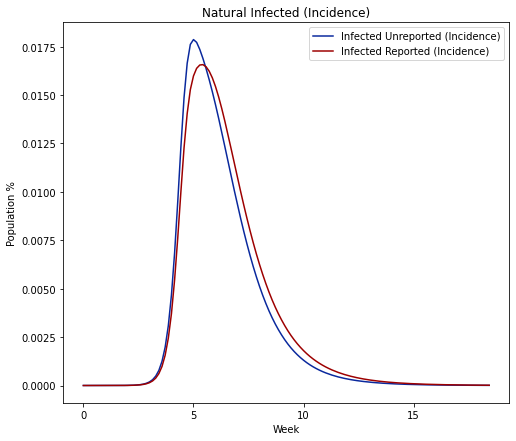

In [23]:

fig = plt.figure()
plt.plot(incidence_unreported/population.sum(), color='#09289D', label='Infected Unreported (Incidence)')
plt.plot(incidence_reported/population.sum(),  color='#9D0000',  label='Infected Reported (Incidence)')

plt.xticks(np.arange(0, 130, step=35), np.arange(0, 20, step=5))  # Set label locations.
plt.xlabel('Week')
plt.ylabel('Population %')
plt.title('Natural Infected (Incidence)')
plt.gcf().set_size_inches(8, 7)
plt.legend(loc=1)
plt.savefig("../Figures/naturalncidence.png")
plt.savefig("../Figures/naturalncidence.svg")

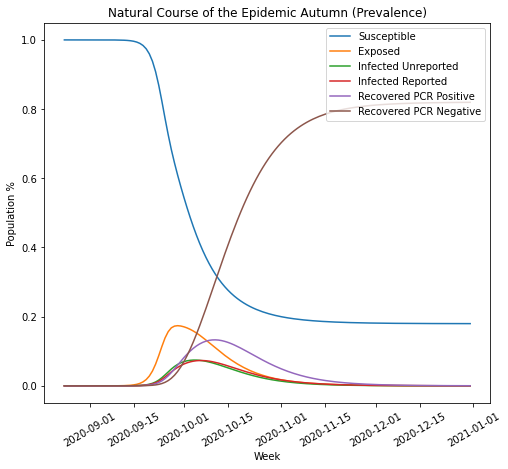

In [34]:

fig = plt.figure()
plt.plot(autumn[:130].index, susceptible/population.sum(), label='Susceptible' )
plt.plot(autumn[:130].index, exposed/population.sum(), label='Exposed')
plt.plot(autumn[:130].index, infected_u/population.sum(), label='Infected Unreported')
plt.plot(autumn[:130].index,  infected_r/population.sum(), label='Infected Reported')
plt.plot(autumn[:130].index, recovered1/population.sum(),  label='Recovered PCR Positive')
plt.plot(autumn[:130].index, recovered2/population.sum(), label='Recovered PCR Negative')

#plt.xticks(np.arange(0, 130, step=35), np.arange(0, 20, step=5))  # Set label locations.
plt.xticks(rotation=30)
plt.xlabel('Week')
plt.ylabel('Population %')
plt.title('Natural Course of the Epidemic Autumn (Prevalence)')
plt.gcf().set_size_inches(8, 7)
plt.legend(loc=1)
plt.savefig("../Figures/naturaPrevalence.png")
plt.savefig("../Figures/naturaPrevalence.svg")
plt.show()